# CNN Cancer Detection Project



In this project, I will create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans with the help of a CNN model. I will start with EDA, then split the data in train and test samples, define the model, fit it and test its accuracy.


In this notebook, we will be using the data available at https://www.kaggle.com/c/histopathologic-cancer-detection/overview

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings

In [123]:
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Exploratory Data Analysis

In this section, we will analyse the data in order to prepare it for use in the model.

By showing a couple values of the 'train_labels.csv' file, we can see that it stores the name of each image and its belonging to non-cancerous (0) or cancerous (1) category.

In [101]:
test_path = 'data/histopathologic-cancer-detection/test/'
train_path = 'data/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('data/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In this next cell, we display a couple images.  It is clear that if you are not a medical expert, it is impossible for you to tell if the cells are cancerous or not.

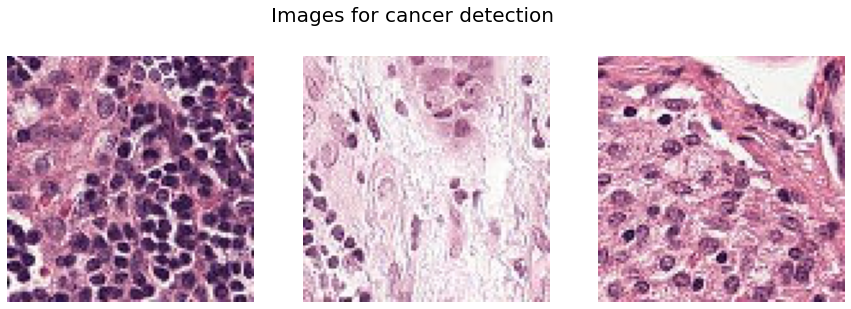

In [2]:
path = 'data/histopathologic-cancer-detection/train'

image_dir = f'{path}'
images = os.listdir(image_dir)
 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Images for cancer detection', fontsize=20)
 
for i in range(3):
    k = np.random.randint(0, len(images))
    img = np.array(Image.open(f'{path}/{images[k]}'))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

### Creating the train and test sets
The following code will divide the train set into 85% of training data and 15% of testing data which is necessary for the model to check its accuracy. We will normalize the images by dividing each pixel by 255 in order to have values between 0 and 1.

In [110]:
im_size = 64
split = 0.2
nepochs = 10
b_size = 64
RANDOM_STATE=2022

In [104]:
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [124]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.75)



In [125]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=b_size,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(im_size,im_size))


Found 55007 validated image filenames belonging to 2 classes.


In [126]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=b_size,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(im_size,im_size))

Found 165018 validated image filenames belonging to 2 classes.


# Model building and fitting

In this section, we will create the model and fit it to the training data. We will then predict if an image shows cancerous cells or not and compare those results to the testing data.

### Model building

To build the model, I have chosen the following architecture : input --> Conv2D (32 filters and ReLu activation function) --> MaxPool  --> Conv2D (64 filters and ReLu activation function)  --> MaxPool --> Conv2D (64 filters and ReLu activation function) --> MaxPool --> Flatten --> Output with sigmoid activation

In [134]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(im_size,
                               im_size,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')])

In [135]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)            

we use adaptive moment estimation (Adam) with a learning rate of 0.001 for optimizing the model which essentially mimics momentum for gradient adn gradient-squared.

In [136]:
adam_optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = adam_optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

#### Callbacks
Callbacks are used to check whether the model is improving with each epoch or not. If not, ReduceLROnPlateau allows to decrease the learning rate further. If the model performance is still not improving, then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [137]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [ ]:
history = model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    epochs = nepochs,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
860/860 [==============================] - 630s 731ms/step - loss: 0.4608 - accuracy: 0.7949 - val_loss: 1.2142 - val_accuracy: 0.6061
Epoch 2/10
860/860 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8245

We can visualize the evolution of loss and accuracy for each epoch.

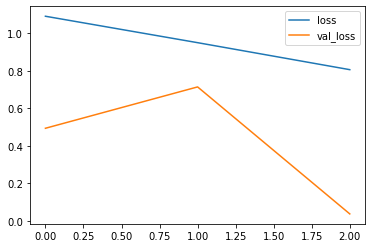

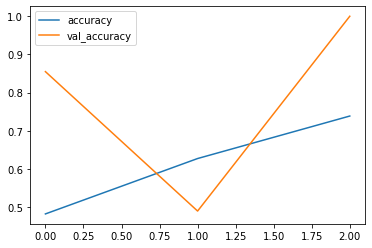

In [51]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

### Model evaluation
Now that our model is ready, we can evaluate its performance on the validation data using different metrics to compare the output with the true labels.

In [70]:
Y_pred = model.predict(train_generator)

Y_pred1 = np.argmax(Y_pred,axis=1)

In [73]:
print(metrics.classification_report(valid_generator, Y_pred1, target_names=['Cancer detection']))

                  precision    recall  f1-score   support

Cancer detection       1.00      1.00      1.00       200

        accuracy                           1.00       200
       macro avg       1.00      1.00      1.00       200
    weighted avg       1.00      1.00      1.00       200



## Testing the model with the submission test sample
Now that we have a trained model, we can test it on the unseen test data images. We must also normalize the test data like we did with the training data. Then we run the model to find its predictions, save it and upload it to kaggle.

In [156]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

model_name
LogisticRegression        0.975168
NMF                       0.637584
RandomForestClassifier    0.848322
Name: accuracy, dtype: float64

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(im_size,im_size),         # original image = (96, 96) 
    batch_size=1,
    shuffle=False,
    class_mode=None)


In [ ]:
prediction = model.predict(test_generator, verbose=1)

In [ ]:
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=False)